In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from IPython.display import display
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt

import pandas_datareader as pdr
import datetime 
import math
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/BTC/bitstampUSD.csv')
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = df.rename(columns={'Volume_(BTC)': 'Volume(BTC)', 'Volume_(Currency)': 'Volume(Currency)','Weighted_Price': 'WeightedPrice'})

In [ ]:
df = df.dropna()

In [ ]:
df.mean()

Timestamp            1.497898e+09
Open                 6.009024e+03
High                 6.013357e+03
Low                  6.004488e+03
Close                6.009014e+03
Volume_(BTC)         9.323249e+00
Volume_(Currency)    4.176284e+04
Weighted_Price       6.008935e+03
dtype: float64

In [ ]:
df.describe()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06
mean,1.497898e+09,6.009024e+03,6.013357e+03,6.004488e+03,6.009014e+03,9.323249e+00,4.176284e+04,6.008935e+03
std,7.443689e+07,8.996247e+03,9.003521e+03,8.988778e+03,8.996360e+03,3.054989e+01,1.518248e+05,8.995992e+03
min,1.325318e+09,3.800000e+00,3.800000e+00,1.500000e+00,1.500000e+00,0.000000e+00,0.000000e+00,3.800000e+00
25%,1.433683e+09,4.438600e+02,4.440000e+02,4.435200e+02,4.438600e+02,4.097759e-01,4.521422e+02,4.438306e+02
50%,1.505880e+09,3.596970e+03,3.598190e+03,3.595620e+03,3.597000e+03,1.979811e+00,3.810124e+03,3.596804e+03
75%,1.562208e+09,8.627270e+03,8.632980e+03,8.621090e+03,8.627160e+03,7.278216e+00,2.569821e+04,8.627637e+03
max,1.617149e+09,6.176356e+04,6.178183e+04,6.167355e+04,6.178180e+04,5.853852e+03,1.390067e+07,6.171621e+04


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3613769 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Timestamp         int64  
 1   Open              float64
 2   High              float64
 3   Low               float64
 4   Close             float64
 5   Volume(BTC)       float64
 6   Volume(Currency)  float64
 7   WeightedPrice     float64
dtypes: float64(7), int64(1)
memory usage: 248.1 MB


In [ ]:
df.isnull().sum()

Timestamp                  0
Open                 1243608
High                 1243608
Low                  1243608
Close                1243608
Volume_(BTC)         1243608
Volume_(Currency)    1243608
Weighted_Price       1243608
dtype: int64

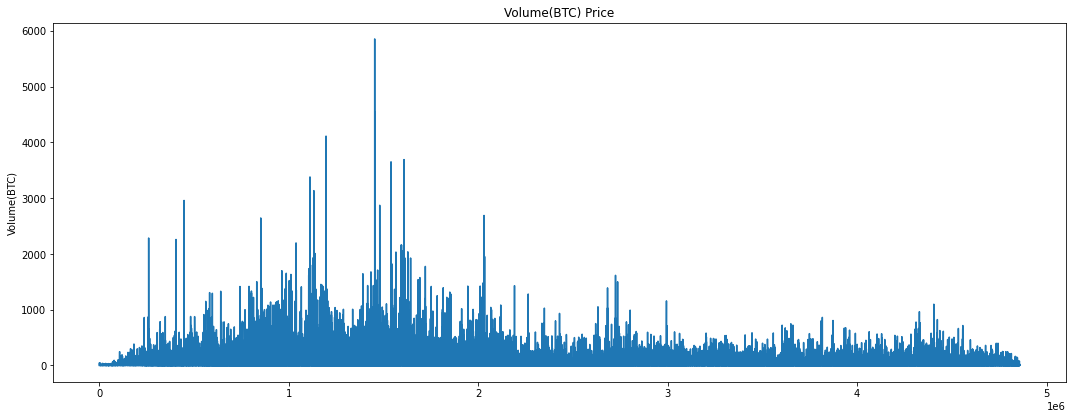

In [ ]:
# Let's see a historical view of the closing price


plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)

.
df['Volume(BTC)'].plot()
plt.ylabel('Volume(BTC)')
plt.xlabel(None)
plt.title(f"Volume(BTC) Price")
    
plt.tight_layout()

Text(0.5, 1.0, 'WeightedPrice')

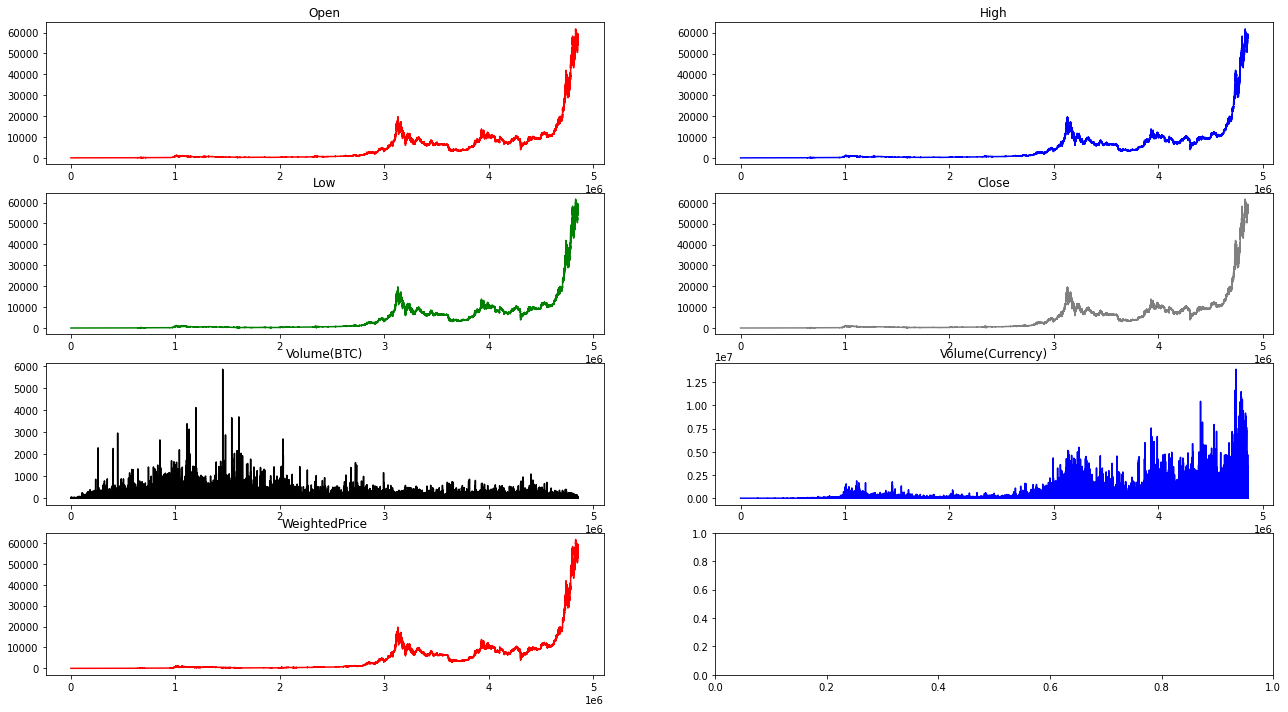

In [ ]:
rcParams['figure.figsize'] = 22, 12

#plt.plot(df.Volume)
#plt.title('Volume')


fig, axs = plt.subplots(4, 2)

axs[0, 0].plot( df.index, df.Open, color = 'red')
#axs[0, 0].xticks(rotation=45)
axs[0, 0].set_title('Open')
    
axs[0, 1].plot( df.index, df.High, color = 'blue')
axs[0, 1].set_title('High')
    
axs[1, 0].plot( df.index, df.Low, color = 'green')
axs[1, 0].set_title('Low')

axs[1, 1].plot( df.index, df.Close, color = 'grey')
axs[1, 1].set_title('Close')


axs[2, 0].plot( df.index, df['Volume(BTC)'], color = 'black')
axs[2, 0].set_title('Volume(BTC)')

axs[2, 1].plot( df.index, df['Volume(Currency)'], color = 'blue')
axs[2, 1].set_title('Volume(Currency)')


axs[3, 0].plot( df.index, df.WeightedPrice, color = 'red')
axs[3, 0].set_title('WeightedPrice')


0           0.455581
478        24.491926
547        29.048119
548        23.867798
1224       19.193647
             ...    
4857372     1.359790
4857373     1.490231
4857374     1.494966
4857375     1.477943
4857376     1.505083
Name: Volume(BTC), Length: 3613769, dtype: float64


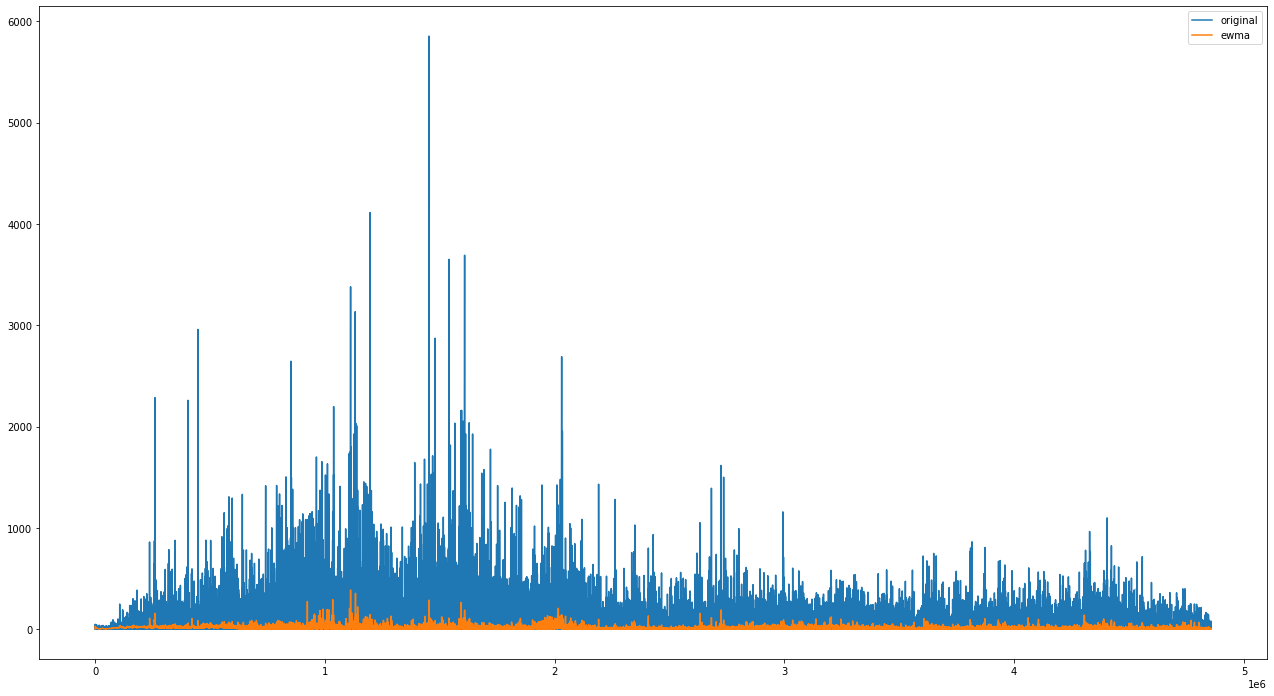

In [ ]:
# Calculation of index-weighted moving average
ewm_mean = df['Volume(BTC)'].ewm(span=90).mean()  

# Display exponentially weighted moving average
print(ewm_mean)

# Visualizing Exponentially Weighted Moving Averages
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(df['Volume(BTC)'], label='original')
ax.plot(ewm_mean, label='ewma')
ax.legend()
plt.show()

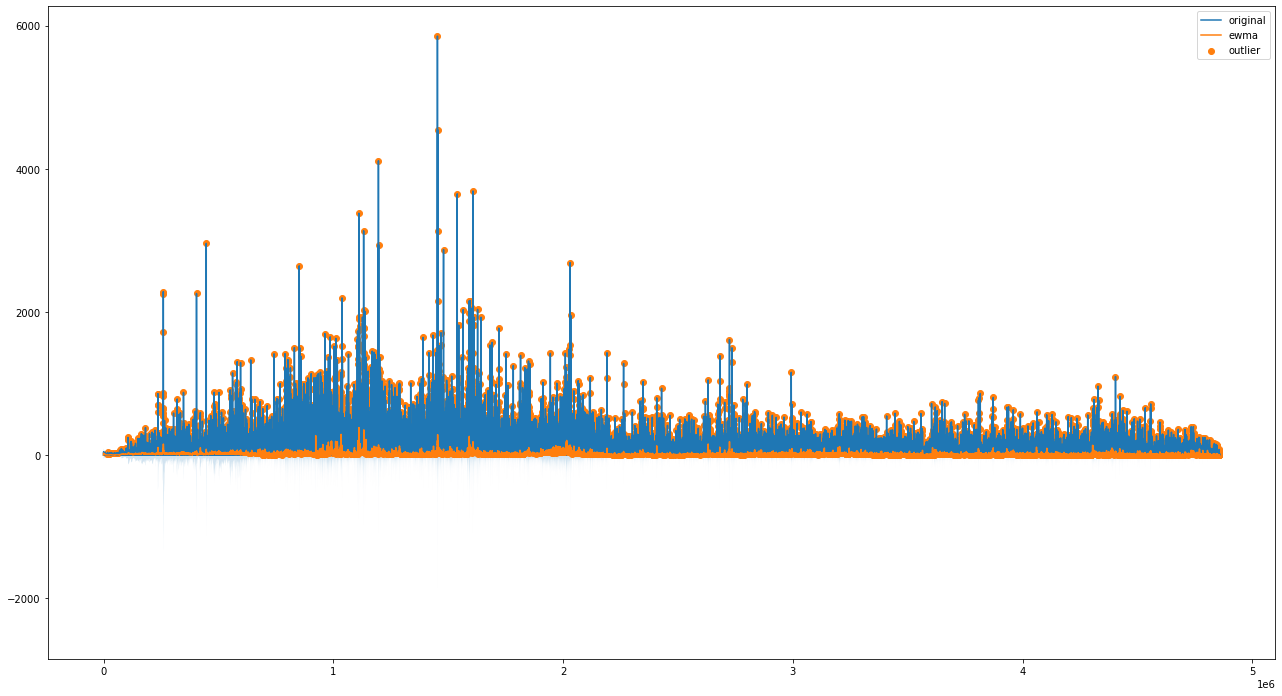

In [ ]:
def plot_outlier(ts, ewm_span=90, threshold=3.0):

    fig, ax = plt.subplots()
    # Calculation of index-weighted moving average
    ewm_mean = ts.ewm(span=ewm_span).mean()  
    # Calculation of exponentially weighted moving standard deviation
    ewm_std = ts.ewm(span=ewm_span).std()  
    ax.plot(ts, label='original')
    ax.plot(ewm_mean, label='ewma')

    # Plot data that are more than 3.0 times out of the standard deviation as outliers.
    ax.fill_between(ts.index,
                    ewm_mean - ewm_std * threshold,
                    ewm_mean + ewm_std * threshold,
                    alpha=0.2)
    outlier = ts[(ts - ewm_mean).abs() > ewm_std * threshold]
    ax.scatter(outlier.index, outlier, label='outlier')
    ax.legend()
    plt.show()
    return fig,outlier

fig,out_fil = plot_outlier(df['Volume(BTC)'],ewm_span=90, threshold=3.0);

In [ ]:
df[df.index.isin(out_fil.index)]

,Timestamp,Open,High,Low,Close,Volume(BTC),Volume(Currency),WeightedPrice
16233,1326291900,7.22,7.33,7.22,7.33,12.922990,9.398726e+01,7.272872
17630,1326375720,7.38,7.38,7.38,7.38,39.400000,2.907720e+02,7.380000
25387,1326841140,6.00,6.00,6.00,6.00,15.532369,9.319421e+01,6.000000
25390,1326841320,6.00,6.00,6.00,6.00,20.267631,1.216058e+02,6.000000
25535,1326850020,5.99,5.99,5.99,5.99,17.661898,1.057948e+02,5.990000
...,...,...,...,...,...,...,...,...
4857186,1617137400,58693.13,58693.13,58622.70,58644.85,11.050399,6.483300e+05,58670.279569
4857196,1617138000,58644.04,58670.91,58591.06,58591.06,9.979587,5.850057e+05,58620.228970
4857261,1617141900,58788.77,58788.77,58701.46,58707.77,12.742887,7.487494e+05,58758.220339
4857359,1617147780,58608.96,58608.96,58606.95,58608.38,17.443451,1.022333e+06,58608.402406


In [ ]:
# Extract records that do not have outliers
df = df[~df.index.isin(out_fil.index)]

In [ ]:
# Calculation of index-weighted moving average
ewm_mean = df['Volume(BTC)'].ewm(span=90).mean()  
df['ewm_mean'] = ewm_mean

In [ ]:
# Completing missing values with exponentially weighted moving averages
df.loc[df['Volume(BTC)'].isnull(),'Volume(BTC)']=df[df['Volume(BTC)'].isnull()]['ewm_mean']
df.loc[df['WeightedPrice'].isnull(),'WeightedPrice']=df[df['WeightedPrice'].isnull()]['ewm_mean']

In [ ]:
# Unix-time to 
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')

# Resampling to daily frequency
df.index = df.Timestamp
df = df.resample('D').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()

In [ ]:
df_month = df.sort_values("Timestamp").reset_index()

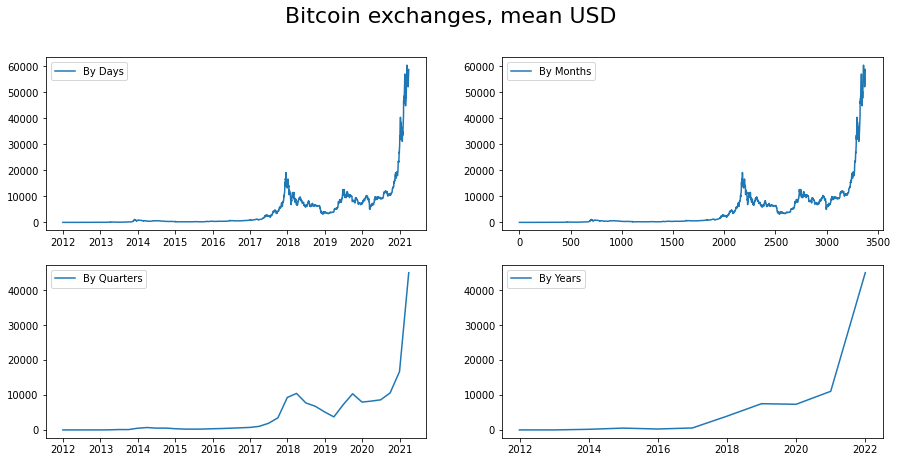

In [ ]:
# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df.WeightedPrice, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.WeightedPrice, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.WeightedPrice, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.WeightedPrice, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

In [ ]:
# Extraction of specific columns
df_new = df.loc[:, ['Open', 'High', 'Low', 'Close']]
df_close = df.loc[:, ['Close']]

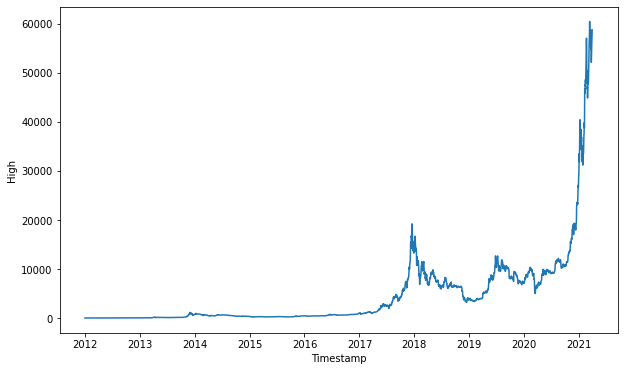

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.lineplot(x=df_new.index, y="High", data=df_new)
plt.show()

In [ ]:
print(df_new)

                    Open          High           Low         Close
Timestamp                                                         
2011-12-31      4.465000      4.482500      4.465000      4.482500
2012-01-01      4.806667      4.806667      4.806667      4.806667
2012-01-02      5.000000      5.000000      5.000000      5.000000
2012-01-03      5.252500      5.252500      5.252500      5.252500
2012-01-04      5.200000      5.223333      5.200000      5.223333
...                  ...           ...           ...           ...
2021-03-27  55191.571964  55217.762993  55167.401743  55193.759629
2021-03-28  55833.683552  55857.124491  55810.682356  55834.803310
2021-03-29  56922.331577  56953.040881  56892.686072  56922.536335
2021-03-30  58351.377292  58374.954471  58327.584904  58352.503710
2021-03-31  58767.750000  58778.180000  58755.970000  58778.180000

[3379 rows x 4 columns]


In [ ]:
# Training data
train = df[df_new.index<'2019-01-01']

# Testing data
test = df[df_new.index>='2019-01-01']

In [ ]:
# Creating a SARIMA Model
sarima = sm.tsa.statespace.SARIMAX(df['Volume(BTC)'],order=(2, 1, 3) ,seasonal_order=(0, 2, 2, 12)).fit()

#Model summary display
print(sarima.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        Volume(BTC)   No. Observations:                 3379
Model:             SARIMAX(2, 1, 3)x(0, 2, 2, 12)   Log Likelihood              -10313.644
Date:                            Wed, 01 Sep 2021   AIC                          20643.289
Time:                                    20:41:28   BIC                          20692.232
Sample:                                12-31-2011   HQIC                         20660.794
                                     - 03-31-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5187      0.117     -4.432      0.000      -0.748      -0.289
ar.L2          0.4003      0.065   

In [ ]:
print(sarima.predict('2019-01-01','2021-03-31'))

Timestamp
2019-01-01    5.298385
2019-01-02    4.255675
2019-01-03    5.173146
2019-01-04    4.037469
2019-01-05    5.296555
                ...   
2021-03-27    3.220884
2021-03-28    2.352716
2021-03-29    2.495209
2021-03-30    2.770220
2021-03-31    2.919480
Freq: D, Length: 821, dtype: float64


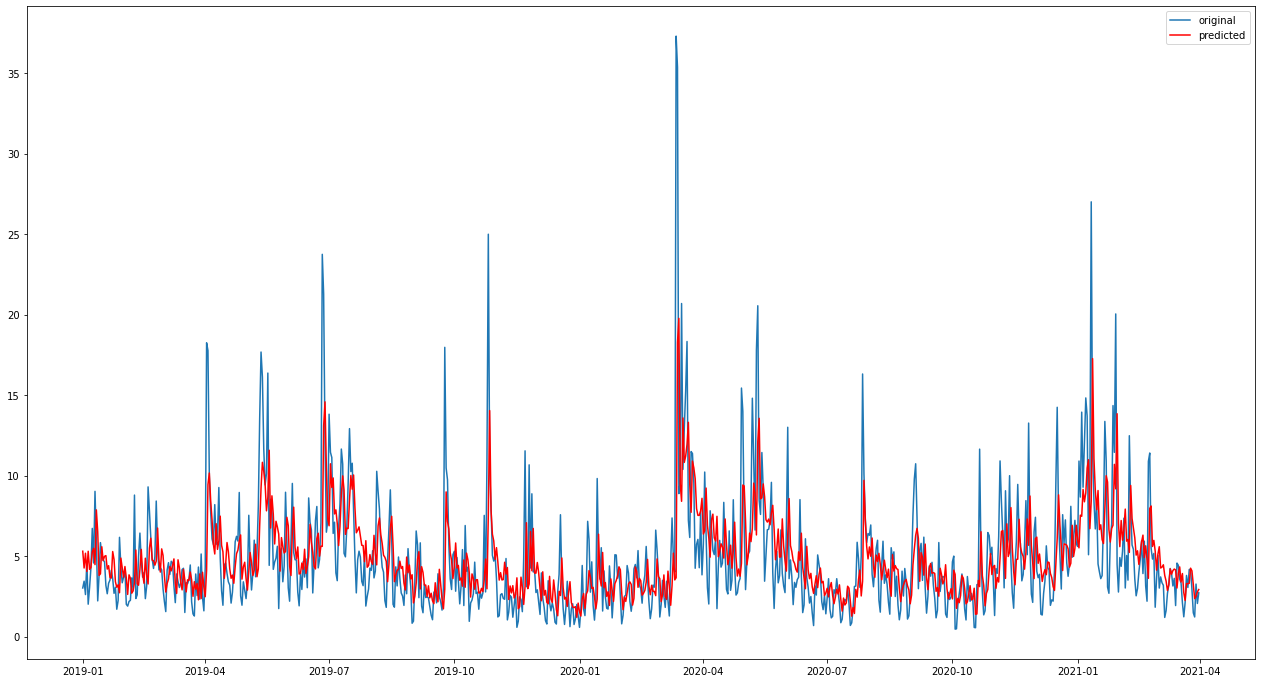

In [ ]:
# Graphical representation of real data and prediction results
plt.plot(test['Volume(BTC)'], label='original')
plt.plot(sarima.predict('2019-01-01','2021-03-31'), label='predicted', color='red')
plt.legend(loc='best')
plt.show()

In [ ]:
print(sarima.predict('20２１-04-01','2030-03-31'))

2021-04-01     2.532717
2021-04-02     2.473020
2021-04-03     3.197956
2021-04-04     2.768152
2021-04-05     2.919534
                ...    
2030-03-27   -11.644047
2030-03-28   -10.871695
2030-03-29    -9.955811
2030-03-30   -10.496638
2030-03-31   -11.609039
Freq: D, Length: 3287, dtype: float64
